In [1]:
# ========================================
# 0) Imports & Config
# ========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, TimeSeriesSplit, learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Make plots a bit larger
plt.rcParams["figure.figsize"] = (7, 5)
np.random.seed(42)


In [3]:
# ========================================
# 1) Data Generation (Supply Chain)
# ========================================
days = pd.date_range(start="2024-01-01", periods=180, freq="D")
temperature = 20 + 7*np.sin(np.linspace(0, 3*np.pi, len(days))) + np.random.normal(0, 2, len(days))
promotion = np.random.choice([0, 1], size=len(days), p=[0.7, 0.3])

# True data-generating process (unknown to the model)
base = 220 + 2.2*temperature + 55*promotion
noise = np.random.normal(0, 15, len(days))
demand = base + noise

data = pd.DataFrame({
    "date": days,
    "temperature": temperature,
    "promotion": promotion,
    "demand": demand
})

data.head()

,date,temperature,promotion,demand
0,2024-01-01,20.993428,0,253.912232
1,2024-01-02,20.091868,1,350.587918
2,2024-01-03,22.031149,0,253.378267
3,2024-01-04,24.147168,0,254.910940
4,2024-01-05,20.995085,0,283.560851


In [5]:
# ========================================
# 2) Train/Test Split (No Shuffle)
# ========================================
X = data[["temperature", "promotion"]]
y = data["demand"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

len(X_train), len(X_test)


(144, 36)

In [7]:
# ========================================
# 3) Train Model
# ========================================
model = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


In [9]:
# ========================================
# 4) Metrics
# ========================================
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"MAE  : {mae:,.2f}")
print(f"RMSE : {rmse:,.2f}")
print(f"R²   : {r2:,.3f}")


MAE  : 15.64
RMSE : 20.07
R²   : 0.636


C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


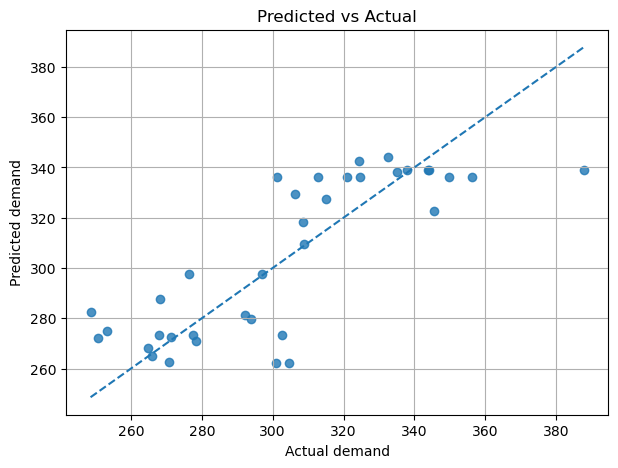

In [11]:
# ========================================
# 5) Predicted vs Actual
# ========================================
plt.figure()
plt.scatter(y_test, y_pred, alpha=0.8)
mn, mx = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
plt.plot([mn, mx], [mn, mx], linestyle="--")
plt.xlabel("Actual demand")
plt.ylabel("Predicted demand")
plt.title("Predicted vs Actual")
plt.grid(True)
plt.show()


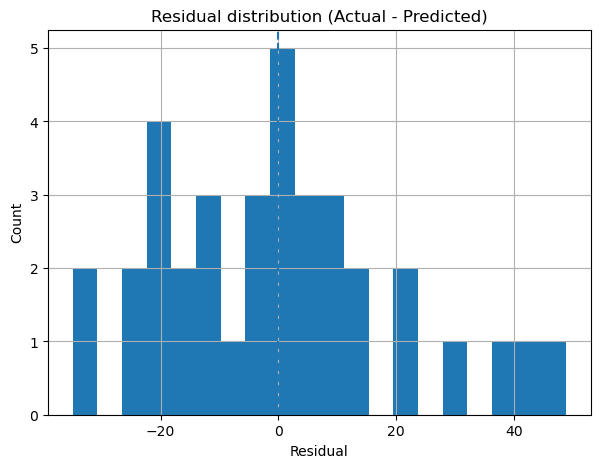

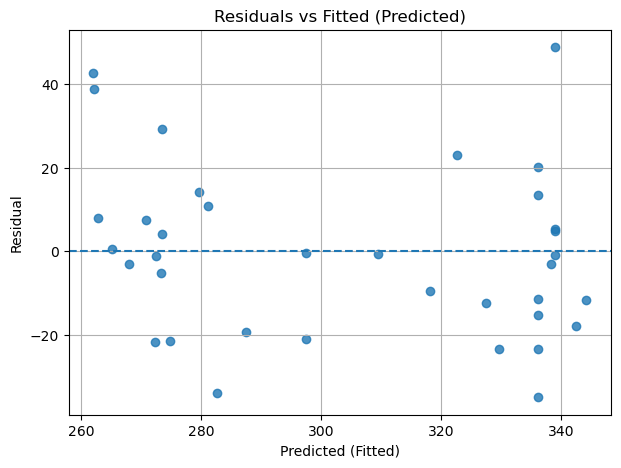

In [13]:
# ========================================
# 6) Residuals: histogram and vs fitted
# ========================================
residuals = y_test - y_pred

# Histogram
plt.figure()
plt.hist(residuals, bins=20)
plt.axvline(0, linestyle="--")
plt.title("Residual distribution (Actual - Predicted)")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# Residuals vs Fitted
plt.figure()
plt.scatter(y_pred, residuals, alpha=0.8)
plt.axhline(0, linestyle="--")
plt.title("Residuals vs Fitted (Predicted)")
plt.xlabel("Predicted (Fitted)")
plt.ylabel("Residual")
plt.grid(True)
plt.show()


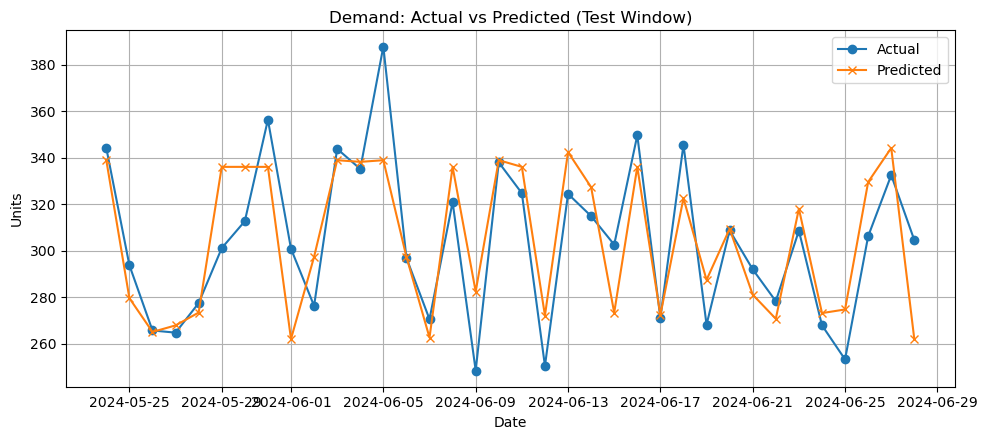

In [15]:
# ========================================
# 7) Time Series Comparison
# ========================================
test_dates = data.loc[y_test.index, "date"]

plt.figure(figsize=(10, 4.5))
plt.plot(test_dates, y_test.values, marker="o", label="Actual")
plt.plot(test_dates, y_pred, marker="x", label="Predicted")
plt.title("Demand: Actual vs Predicted (Test Window)")
plt.xlabel("Date")
plt.ylabel("Units")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


MAE by fold: [12.17, 33.03, 14.33, 12.94, 16.55]
MAE mean ± std: 17.81 ± 7.76


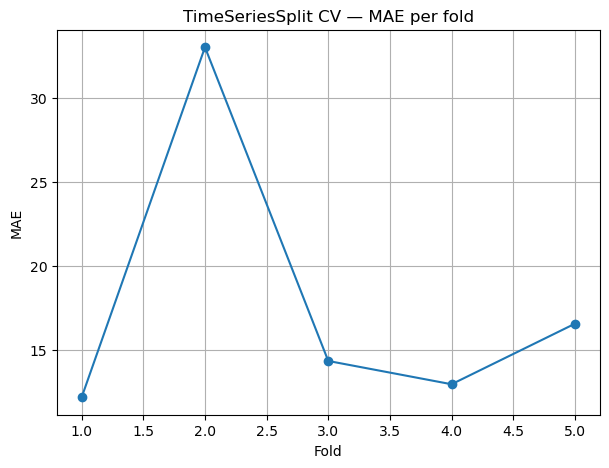

In [17]:
# ========================================
# 8) TimeSeriesSplit Cross-Validation (MAE)
# ========================================
tscv = TimeSeriesSplit(n_splits=5)

fold_mae = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
    X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

    m = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
    m.fit(X_tr, y_tr)
    pred_val = m.predict(X_val)
    fold_mae.append(mean_absolute_error(y_val, pred_val))

print("MAE by fold:", [round(v, 2) for v in fold_mae])
print("MAE mean ± std:", round(np.mean(fold_mae), 2), "±", round(np.std(fold_mae), 2))

plt.figure()
plt.plot(range(1, len(fold_mae)+1), fold_mae, marker="o")
plt.title("TimeSeriesSplit CV — MAE per fold")
plt.xlabel("Fold")
plt.ylabel("MAE")
plt.grid(True)
plt.show()


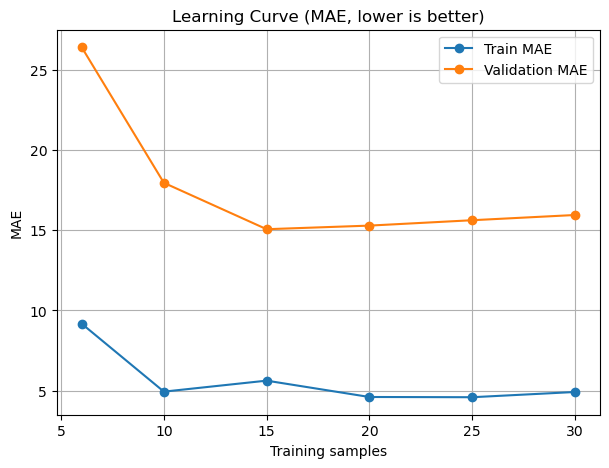

In [19]:
# ========================================
# 9) Learning Curve
# ========================================
train_sizes, train_scores, val_scores = learning_curve(
    estimator=RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1),
    X=X, y=y,
    train_sizes=np.linspace(0.2, 1.0, 6),
    cv=TimeSeriesSplit(n_splits=5),
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    shuffle=False
)

train_mae = -train_scores.mean(axis=1)
val_mae = -val_scores.mean(axis=1)

plt.figure()
plt.plot(train_sizes, train_mae, marker="o", label="Train MAE")
plt.plot(train_sizes, val_mae, marker="o", label="Validation MAE")
plt.title("Learning Curve (MAE, lower is better)")
plt.xlabel("Training samples")
plt.ylabel("MAE")
plt.legend()
plt.grid(True)
plt.show()


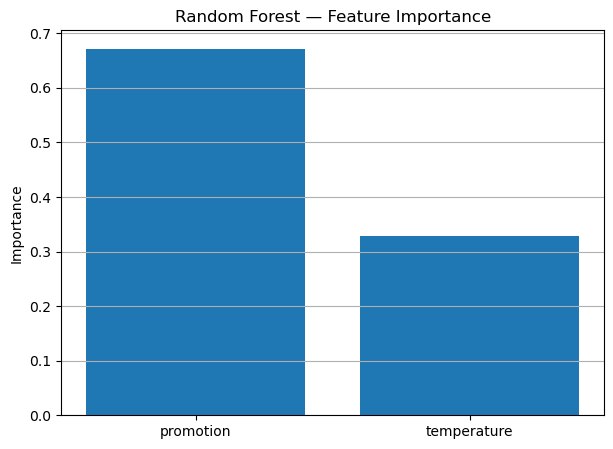

{'promotion': 0.672, 'temperature': 0.328}

In [21]:
# ========================================
# 10) Feature Importance
# ========================================
importances = model.feature_importances_
feat_order = np.argsort(importances)[::-1]
feat_names = X.columns[feat_order]
feat_vals = importances[feat_order]

plt.figure()
plt.bar(feat_names, feat_vals)
plt.title("Random Forest — Feature Importance")
plt.ylabel("Importance")
plt.grid(axis="y")
plt.show()

dict(zip(feat_names, np.round(feat_vals, 3)))


In [ ]:
## 📌 Summary — Model Validation Workflow Recap

In this notebook, we **evaluated a regression model** for *supply chain daily demand forecasting* using a **Random Forest**.  
We simulated data with two main drivers: **temperature** (seasonality) and **promotion** (binary events), plus random noise.  

**Steps we covered:**
1. **Data Simulation** – created realistic demand data with external drivers.  
2. **Train/Test Split (time-aware)** – no shuffling to mimic real forecasting.  
3. **Model Training** – Random Forest baseline model.  
4. **Performance Metrics** – MAE, RMSE, R² for numerical assessment.  
5. **Predicted vs Actual Plot** – goodness-of-fit visual check.  
6. **Residual Analysis** – distribution and vs-fitted plots to detect bias and structure.  
7. **Time Series Comparison** – tracked prediction vs actual over test period.  
8. **TimeSeriesSplit Cross-Validation** – assessed stability over multiple folds.  
9. **Learning Curve** – diagnosed underfitting/overfitting and data sufficiency.  
10. **Feature Importance** – interpreted main demand drivers for business context.

**Key takeaways:**
- Metrics give numbers, but **plots reveal patterns** and issues (bias, variance, missed peaks).  
- For supply chain, *visual inspection* is crucial — seasonal peaks, promotions, and anomalies often matter more than small average errors.  
- Using **time-aware validation** prevents overly optimistic results.  
- Always connect insights back to **business decisions**: e.g., promotions had high feature importance → align marketing with stock availability.
